Table 1 – Standard VE (2 M vanadium)
| Redox Couple     | Limiting Species   | Concentration (M) standard   |   Total Charge Stored (Ah L⁻¹) |   Average Cell Voltage (V) |
|:-----------------|:-------------------|:-----------------------------|-------------------------------:|---------------------------:|
| VIV/V-VII/III    | V                  | 1.8∥2.0                      |                          42.55 |                      1.191 |
| CeIII/IV-VII/III | Ce                 | 1.5∥2.0                      |                          35.46 |                      1.911 |
| Br-/Br2-VII/III  | V                  | 3.0∥2.0                      |                          47.28 |                      1.294 |
| FeII/III-VII/III | Fe                 | 2.0∥2.0                      |                          47.28 |                      0.961 |
| MnII/III-VII/III | V                  | 2.5∥2.0                      |                          47.28 |                      1.701 |
| VIV/V-Zn        

/tmp/ipython-input-596565655.py:237: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


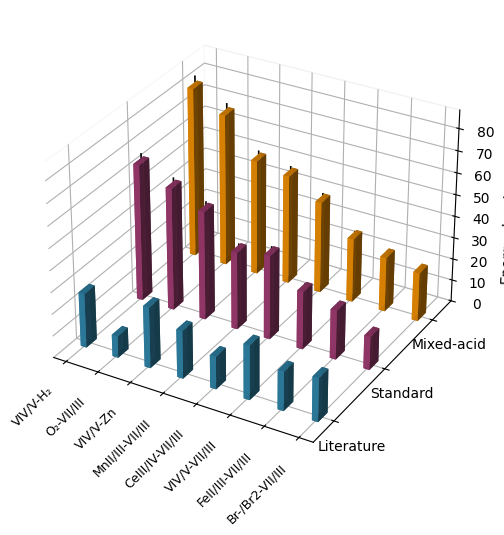

In [4]:
#!/usr/bin/env python3
"""
Flow Battery Energy Density Calculator
-----------------------------------------------
- Full BV+MT equation for liquid couples (6)
- Simplified gas equation (ED ∝ E⁰) for gas couples (2)
- Gas-side SOC fixed to 1 in both calculations and tables
- 4 tables + 3-D bar chart (ordered by calculated ED)
Author : <Kourosh Khaje>
Date   : 2026-01-01
"""

import numpy as np
import pandas as pd
from scipy.integrate import quad
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa – 3-D support

# ------------------------------------------------------------------
# Physical constants
# ------------------------------------------------------------------
R, T, F = 8.314, 298.15, 96485
RT_F = R * T / F
RT_zF = lambda z: RT_F / z

j_op  = 0.1          # A cm⁻²
DSOC  = 0.9          # 90 % swing (5 % → 95 %)
η_c   = 0.98         # 98 % coulombic efficiency

# Kinetic / transport parameters (liquid couples only)
j0_pos = 0.08
j0_neg = 0.08
jL_pos = 0.30
jL_neg = 0.30
R_ohm  = 0.18        # Ohm cm²

# ------------------------------------------------------------------
# Thermodynamic database
# ------------------------------------------------------------------
base = {
    'VIV/V-VII/III':      {'E0': 1.26, 'zp': 1, 'zn': 1, 'c_pos': 1.8, 'c_neg': 1.8, 'limit_elem': 'V',    'gas': None},
    'CeIII/IV-VII/III':   {'E0': 1.98, 'zp': 1, 'zn': 1, 'c_pos': 1.5, 'c_neg': 1.8, 'limit_elem': 'Ce',   'gas': None},
    'Br-/Br2-VII/III':    {'E0': 1.35, 'zp': 2, 'zn': 1, 'c_pos': 3.0, 'c_neg': 1.8, 'limit_elem': 'V',    'gas': None},
    'FeII/III-VII/III':   {'E0': 1.03, 'zp': 1, 'zn': 1, 'c_pos': 2.0, 'c_neg': 1.8, 'limit_elem': 'Fe',   'gas': None},
    'MnII/III-VII/III':   {'E0': 1.77, 'zp': 1, 'zn': 1, 'c_pos': 2.5, 'c_neg': 1.8, 'limit_elem': 'V',    'gas': None},
    'VIV/V-Zn':           {'E0': 1.76, 'zp': 1, 'zn': 2, 'c_pos': 1.8, 'c_neg': 2.0, 'limit_elem': 'Zn',   'gas': None},
    'O₂-VII/III':         {'E0': 1.49, 'zp': 4, 'zn': 1, 'c_pos': 1e4, 'c_neg': 1.8, 'limit_elem': 'V',    'gas': 'O₂'},
    'VIV/V-H₂':           {'E0': 1.00, 'zp': 1, 'zn': 2, 'c_pos': 1.8, 'c_neg': 1e4, 'limit_elem': 'V',    'gas': 'H₂'},
}

# Literature look-up (Wh L⁻¹)
lit_lookup = {
    'VIV/V-VII/III': 25,
    'CeIII/IV-VII/III': 15,
    'Br-/Br2-VII/III': 20,
    'FeII/III-VII/III': 18,
    'MnII/III-VII/III': 22,
    'VIV/V-Zn': 28,
    'O₂-VII/III': 10,
    'VIV/V-H₂': 25,
}

# ------------------------------------------------------------------
# Polarisation helpers (liquid couples only)
# ------------------------------------------------------------------
def eta_bv(j, j0, z):
    return RT_zF(z) * np.arcsinh(j / (2 * j0))

def eta_mt(j, jL, z):
    return -RT_zF(z) * np.log(1 - j / jL)

# ------------------------------------------------------------------
# Core calculation
# ------------------------------------------------------------------
def run_single(c_V, label='standard'):
    rows = []
    for name, d in base.items():
        zp, zn, E0 = d['zp'], d['zn'], d['E0']
        gas = d['gas']

        # concentrations
        if gas is None:
            c_pos, c_neg = d['c_pos'], c_V
        elif gas == 'O₂':
            c_pos, c_neg = c_V, c_V
        elif gas == 'H₂':
            c_pos, c_neg = c_V, c_V

        c_str = f"{d['c_pos']}∥{c_V}" if gas is None else (f"{c_V}∥–" if gas == 'O₂' else f"–∥{c_V}")

        # volume ratio
        ratio_V = (c_pos * zp) / (c_neg * zn)
        V_pos = 1.0
        V_neg = ratio_V * V_pos
        V_tot = V_pos + V_neg

        # capacity
        if gas is None:
            c_lim, z_lim = (c_pos if (c_pos * zp) <= (c_neg * zn) else c_neg), (zp if (c_pos * zp) <= (c_neg * zn) else zn)
        else:
            c_lim, z_lim = c_V, (zp if gas == 'O₂' else zn)

        Q_L = c_lim * z_lim * F * DSOC * η_c
        Ah_L = Q_L / 3600

        # voltage model
        if gas is None:  # liquid couples → full BV+MT, SOC on both sides
            def V_inst(soc_p, soc_n):
                return (
                    E0
                    + RT_zF(zp) * np.log(soc_p / (1 - soc_p))
                    - RT_zF(zn) * np.log(soc_n / (1 - soc_n))
                    - eta_bv(j_op, j0_pos, zp) - eta_bv(j_op, j0_neg, zn)
                    - j_op * R_ohm
                    - eta_mt(j_op, jL_pos, zp) - eta_mt(j_op, jL_neg, zn)
                )
            soc_low = (1 - DSOC) / 2
            soc_high = (1 + DSOC) / 2
            V_avg, _ = quad(lambda s: V_inst(s, s), soc_low, soc_high)
            V_avg /= DSOC
            SOC_pos_str = f"{soc_low*100:.0f}–{soc_high*100:.0f}"
            SOC_neg_str = SOC_pos_str
        else:  # gas couples → simplified, gas side SOC = 1
            V_avg = E0
            SOC_pos_str = "1" if gas == 'O₂' else f"{(1-DSOC)/2*100:.0f}–{(1+DSOC)/2*100:.0f}"
            SOC_neg_str = "1" if gas == 'H₂' else f"{(1-DSOC)/2*100:.0f}–{(1+DSOC)/2*100:.0f}"

        ED_model = Ah_L * V_avg / (V_tot / V_pos)

        lit = lit_lookup[name]
        err = 100 * (ED_model - lit) / lit

        rows.append({
            'Redox Couple': name,
            'Limiting Species': base[name]['limit_elem'],
            f'Concentration (M) {label}': c_str,
            'Total Charge Stored (Ah L⁻¹)': round(Ah_L, 2),
            'Average Cell Voltage (V)': round(V_avg, 3),
            'ED Model (Wh L⁻¹)': round(ED_model, 1),
            'ED Literature (Wh L⁻¹)': lit,
            'Error (%)': round(err, 1),
            'SOC Positive (%)': SOC_pos_str,
            'SOC Negative (%)': SOC_neg_str
        })
    return pd.DataFrame(rows)

# ------------------------------------------------------------------
# Build tables
# ------------------------------------------------------------------
df_std = run_single(2.0, 'standard')
df_mix = run_single(2.5, 'mixed acid')

# Table 1
print('Table 1 – Standard VE (2 M vanadium)')
print(df_std[['Redox Couple', 'Limiting Species', 'Concentration (M) standard',
              'Total Charge Stored (Ah L⁻¹)', 'Average Cell Voltage (V)']].to_markdown(index=False))
print('\n')

# Table 2
print('Table 2 – Mixed-acid VE (2.5 M vanadium)')
print(df_mix[['Redox Couple', 'Limiting Species', 'Concentration (M) mixed acid',
              'Total Charge Stored (Ah L⁻¹)', 'Average Cell Voltage (V)']].to_markdown(index=False))
print('\n')

# Table 3 – comparison
tbl3 = pd.merge(df_std[['Redox Couple', 'ED Model (Wh L⁻¹)', 'ED Literature (Wh L⁻¹)']].rename(
                columns={'ED Model (Wh L⁻¹)': 'ED Model (Wh L⁻¹) Standard'}),
                df_mix[['Redox Couple', 'ED Model (Wh L⁻¹)']].rename(
                columns={'ED Model (Wh L⁻¹)': 'ED Model (Wh L⁻¹) Mixed Acid'}),
                on='Redox Couple')
tbl3['Error (%) Standard']   = round(100 * (tbl3['ED Model (Wh L⁻¹) Standard'] - tbl3['ED Literature (Wh L⁻¹)']) / tbl3['ED Literature (Wh L⁻¹)'], 1)
tbl3['Error (%) Mixed Acid'] = round(100 * (tbl3['ED Model (Wh L⁻¹) Mixed Acid'] - tbl3['ED Literature (Wh L⁻¹)']) / tbl3['ED Literature (Wh L⁻¹)'], 1)
tbl3['Increase (%)']         = round(100 * (tbl3['ED Model (Wh L⁻¹) Mixed Acid'] - tbl3['ED Model (Wh L⁻¹) Standard']) / tbl3['ED Model (Wh L⁻¹) Standard'], 1)

print('Table 3 – Comparison Standard vs. Mixed-acid')
print(tbl3[['Redox Couple', 'ED Literature (Wh L⁻¹)',
            'ED Model (Wh L⁻¹) Standard', 'Error (%) Standard',
            'ED Model (Wh L⁻¹) Mixed Acid', 'Error (%) Mixed Acid',
            'Increase (%)']].to_markdown(index=False))
print('\n')

# Table 4 – SOC
soc = df_std[['Redox Couple', 'SOC Positive (%)', 'SOC Negative (%)']].copy()
soc.insert(1, 'SOC Positive (%) Mixed Acid', soc['SOC Positive (%)'])
soc.insert(3, 'SOC Negative (%) Mixed Acid', soc['SOC Negative (%)'])
print('Table 4 – SOC window used for each half-cell')
print(soc.to_markdown(index=False))
print('\n')

# ------------------------------------------------------------------
# 3-D bar chart – ordered by mixed-acid ED (descending)
# ------------------------------------------------------------------
order = tbl3.sort_values(by='ED Model (Wh L⁻¹) Mixed Acid', ascending=False).index
couples_ordered = tbl3.loc[order, 'Redox Couple'].values
literature = tbl3.loc[order, 'ED Literature (Wh L⁻¹)'].values
standard   = tbl3.loc[order, 'ED Model (Wh L⁻¹) Standard'].values
mixed      = tbl3.loc[order, 'ED Model (Wh L⁻¹) Mixed Acid'].values

x = np.arange(len(couples_ordered))
dx = dy = 0.18
y_pos = np.array([0, 1, 2])
colors = ["#2E86AB", "#A23B72", "#F18F01"]

err_lit = literature * 0.03
err_std = standard   * 0.05
err_mix = mixed      * 0.05

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

for y_base, height, err, color in zip(
        [np.zeros_like(x), np.ones_like(x), np.full_like(x, 2)],
        [literature, standard, mixed],
        [err_lit, err_std, err_mix],
        colors):

    ax.bar3d(x, y_base, np.zeros_like(x), dx, dy, height, color=color, alpha=0.9)
    for xx, yy, zz, ee in zip(x, y_base, height, err):
        ax.plot([xx+dx/2]*2, [yy+dy/2]*2, [zz-ee, zz+ee], color="k", lw=1.2)

# polish
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.xaxis.pane.fill = ax.yaxis.pane.fill = ax.zaxis.pane.fill = False
ax.grid(True, linestyle=':', linewidth=0.6, color='grey')

ax.set_xticks(x + dx/2)
ax.set_xticklabels(couples_ordered, rotation=45, ha='right', fontsize=9)
ax.set_yticks(y_pos + dy/2)
ax.set_yticklabels(["Literature", "Standard", "Mixed-acid"])
ax.set_zlabel('Energy density (Wh L$^{-1}$)')

ax.set_xlim(-0.3, x.max() + 0.5)
ax.set_ylim(-0.3, 2.5)
ax.set_zlim(0, max(mixed.max(), standard.max(), literature.max()) * 1.12)

plt.tight_layout()
plt.show()